In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc, precision_score, recall_score, precision_recall_curve

In [2]:
df = pd.read_csv('df_total_sp.csv')
df = df.drop(columns = ['SG_UF','NU_IDADE_N'])

In [3]:
df

,CRITERIO,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,DOR_COSTAS,CONJUNTVIT,ARTRITE,ARTRALGIA,PETEQUIA_N,LEUCOPENIA,LACO,DOR_RETRO,CHIK
0,EpiClinico,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,Laboratorial,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
2,EpiClinico,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0
3,EpiClinico,1,1,1,0,0,0,1,0,1,1,0,0,0,1,0
4,Laboratorial,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1761395,Laboratorial,1,1,1,1,1,1,1,0,1,0,0,0,0,1,1
1761396,Laboratorial,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1
1761397,Laboratorial,1,1,1,0,1,1,0,0,0,0,0,0,0,0,1
1761398,Laboratorial,1,1,1,0,0,1,1,0,0,1,0,0,0,1,1


In [4]:
df_lab = df[df['CRITERIO'] == 'Laboratorial']
df_lab = df_lab.reset_index(drop = True)
df_epi = df[df['CRITERIO'] == 'EpiClinico'] 
df_epi = df_epi.reset_index(drop = True)
df_lab = df_lab.drop(columns = ['CRITERIO'])
df_epi = df_epi.drop(columns = ['CRITERIO'])

### Train-test split

In [5]:
X = df_lab.iloc[:,0:13]
y = df_lab.iloc[:,14]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.6, random_state = 0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify = y_test, test_size = 0.5, random_state = 0)

In [6]:
print('Train: ', y_train.shape, sum(y_train == 1), sum(y_train == 0))
print('Test: ', y_test.shape, sum(y_test == 1), sum(y_test == 0))
print('Validation: ', y_val.shape, sum(y_val == 1), sum(y_val == 0))

Train:  (342966,) 2368 340598
Test:  (257225,) 1776 255449
Validation:  (257225,) 1776 255449


### Logistic regression

In [7]:
logreg = LogisticRegression(solver='liblinear', random_state=0)
logreg.fit(X_train, y_train)
y_pred_train = logreg.predict_proba(X_train)[:,1]
fpr_1, tpr_1, thresholds = roc_curve(y_train, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train, y_pred_train))

0.7664588783967881


### Random Forest

In [8]:
rfc = RandomForestClassifier(random_state = 0)
rfc.fit(X_train ,y_train)
y_pred_train = rfc.predict_proba(X_train)[:,1]
fpr_2, tpr_2, thresholds = roc_curve(y_train, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train, y_pred_train))

0.8216393482932959


### XGBoost

In [9]:
clx = XGBClassifier(random_state = 0, nthread = 8)
clx.fit(X_train, y_train)
y_pred_train = clx.predict_proba(X_train)[:,1]
fpr_3, tpr_3, thresholds = roc_curve(y_train, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train, y_pred_train))

0.8027653751636827


### Random forest with class weights 

In [10]:
rfc = RandomForestClassifier(random_state = 0, class_weight = 'balanced')
rfc.fit(X_train ,y_train)
y_pred_train = rfc.predict_proba(X_train)[:,1]
fpr_4, tpr_4, thresholds = roc_curve(y_train, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train, y_pred_train))

0.8121350690153393


### Training with subsampling

In [17]:
num_train_chik = sum(y_train == 1)
ind_train_chik = (y_train == 1)

In [18]:
X_train_chik = X_train.loc[ind_train_chik]
y_train_chik = y_train.loc[ind_train_chik]
X_train_chik = X_train_chik.reset_index(drop = True)
y_train_chik = y_train_chik.reset_index(drop = True)

In [12]:
ind_train_denv = (y_train == 0)

In [19]:
X_train_denv = X_train.loc[ind_train_denv]
y_train_denv = y_train.loc[ind_train_denv]
X_train_denv = X_train_denv.reset_index(drop = True)
y_train_denv = y_train_denv.reset_index(drop = True)

In [38]:
indexes_denv = np.random.randint(0,X_train_denv.shape[0],num_train_chik)
X_train_denv = X_train_denv.loc[indexes_denv]
X_train_denv = X_train_denv.reset_index(drop = True)
y_train_denv = y_train_denv.loc[indexes_denv]
y_train_denv = y_train_denv.reset_index(drop = True)

In [40]:
X_train_2 = pd.concat([X_train_denv, X_train_chik])
y_train_2 = pd.concat([y_train_denv, y_train_chik])

In [42]:
logreg = LogisticRegression(solver='liblinear', random_state=0)
logreg.fit(X_train_2, y_train_2)
y_pred_train = logreg.predict_proba(X_train_2)[:,1]
fpr_5, tpr_5, thresholds = roc_curve(y_train_2, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train_2, y_pred_train))

0.7710536067898557


In [44]:
rfc = RandomForestClassifier(random_state = 0)
rfc.fit(X_train_2 ,y_train_2)
y_pred_train = rfc.predict_proba(X_train_2)[:,1]
fpr_6, tpr_6, thresholds = roc_curve(y_train_2, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train_2, y_pred_train))

0.8337523611554969


In [45]:
clx = XGBClassifier(random_state = 0, nthread = 8)
clx.fit(X_train_2, y_train_2)
y_pred_train = clx.predict_proba(X_train_2)[:,1]
fpr_7, tpr_7, thresholds = roc_curve(y_train_2, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train_2, y_pred_train))

0.8237911918199872


### KNN classifier

In [54]:
knn = KNeighborsClassifier(n_jobs = -1)
knn.fit(X_train, y_train)
y_pred_train = knn.predict_proba(X_train)[:,1]
fpr_8, tpr_8, thresholds = roc_curve(y_train, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train, y_pred_train))

0.5652717663224046


In [55]:
knn = KNeighborsClassifier(n_jobs = -1)
knn.fit(X_train_2, y_train_2)
y_pred_train = knn.predict_proba(X_train_2)[:,1]
fpr_9, tpr_9, thresholds = roc_curve(y_train_2, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train_2, y_pred_train))

0.6777224265545106


### Plotting all classifiers

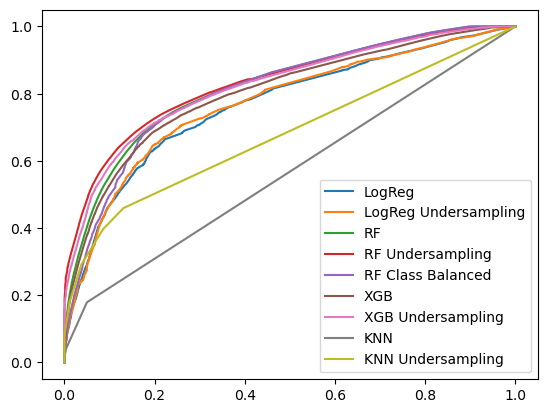

In [56]:
plt.plot(fpr_1, tpr_1, label = 'LogReg')
plt.plot(fpr_5, tpr_5, label = 'LogReg Undersampling')
plt.plot(fpr_2, tpr_2, label = 'RF')
plt.plot(fpr_6, tpr_6, label = 'RF Undersampling')
plt.plot(fpr_4, tpr_4, label = 'RF Class Balanced')
plt.plot(fpr_3, tpr_3, label = 'XGB')
plt.plot(fpr_7, tpr_7, label = 'XGB Undersampling')
plt.plot(fpr_8, tpr_8, label = 'KNN')
plt.plot(fpr_9, tpr_9, label = 'KNN Undersampling')
plt.legend()
plt.show()